In [1]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, 
    f1_score, confusion_matrix, classification_report, top_k_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt






df_micro = pd.read_csv('/Users/admin/Code/Personal/OProjects/CREST/micro_regimes_classified.csv', index_col=0)
df_macro = pd.read_csv('/Users/admin/Code/Personal/OProjects/CREST/macro_features_with_regimes.csv', index_col=0)

In [2]:
df_micro

,NIR,RV,KER,CCI,VIX_Change,NIR_VIX,VIX_smooth,VIX_ADX,Close,micro_regime
Date,,,,,,,,,,
2019-01-22,-0.464012,-0.930598,-0.084941,-0.418844,-0.178366,0.553904,-0.071211,-0.846528,10922.75,Trending_LowVol
2019-01-23,0.056597,-0.870434,0.524705,-0.504813,0.078666,3.055300,-0.031522,-1.122631,10831.50,Trending_LowVol
2019-01-24,-0.648363,-0.869235,-0.668554,-0.547005,-0.656266,1.212008,-0.034850,-0.411081,10849.80,Trending_LowVol
2019-01-25,0.534168,-0.856080,0.294766,-0.545591,0.239204,1.272202,-0.025383,-1.250709,10780.55,Trending_LowVol
2019-01-28,0.527157,-0.877133,0.738878,-0.924815,1.188968,1.929439,0.036264,-0.700159,10661.55,Trending_LowVol
...,...,...,...,...,...,...,...,...,...,...
2025-08-14,-1.026130,0.388465,-0.667711,0.060475,0.301116,-0.539316,-0.764285,0.054175,24631.30,Choppy_LowVol
2025-08-18,-0.577272,0.005486,-0.121399,0.459629,-0.048451,0.223675,-0.756847,-0.093064,24876.95,Trending_LowVol
2025-08-19,-0.731906,-0.323219,0.575851,0.532025,-0.809075,-1.013456,-0.777092,-0.102099,24980.65,Trending_LowVol


In [3]:
# df_merged = df_macro.join(df_micro, how='inner', lsuffix="_macro", rsuffix="_micro")\
# df_merged["target"] = df_merged['final_regime'].shift(1) 

In [4]:
final_columns = [
    "RSI_40d",
    "short_40_long_80_term_diff",
    "max_drawdown_40d",
    "sharpe_like_40d",
    "volatility_40d",
    "VIX_rolling_mean_30d",
    "VIX_rolling_std_30d",
    "nifty_vix_ratio",
    # "Close_macro",
    # "macro_regime",
    "NIR",
    "RV",
    "KER",
    "CCI",
    "VIX_Change",
    "NIR_VIX",
    "VIX_smooth",
    "VIX_ADX",
    # "Close_micro",
    # "micro_regime",
]

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
def runModel(df: pd.DataFrame, regime_column: str):
    features = [col for col in df.columns if col in final_columns]
    regime_encoder = LabelEncoder()
    df["encoded_regime"] = regime_encoder.fit_transform(df[regime_column])
    df['target'] = df[regime_column].shift(1)
    df = df.dropna()  

    X = df[features + ["encoded_regime"]]
    y = df['target']

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, shuffle=True
    )
    sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
    model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
    )

    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    y_pred_labels = le.inverse_transform(y_pred)
    y_test_labels = le.inverse_transform(y_test)

    y_proba = model.predict_proba(X_test)  

    proba_df = pd.DataFrame(y_proba, columns=[f"prob_{cls}" for cls in le.classes_], index=X_test.index)
    results_df = X_test.copy()
    results_df["true_label"] = y_test_labels
    results_df["pred_label"] = y_pred_labels
    results_df = pd.concat([results_df, proba_df], axis=1)

    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
    print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))


    print("\nClassification Report:\n", 
        classification_report(
            y_test, 
            y_pred, 
            labels=range(len(le.classes_)),  # ensures all classes included
            target_names=le.classes_
        )
    )

    cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))    



    labels = range(len(le.classes_))

    print("Top-2 Accuracy:", top_k_accuracy_score(y_test, y_proba, k=2, labels=labels))
    print("Top-3 Accuracy:", top_k_accuracy_score(y_test, y_proba, k=3, labels=labels))

    cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix by Regime")
    plt.show()

    # Feature importance
    xgb.plot_importance(model, max_num_features=15, importance_type="gain")
    plt.show()

    return results_df  

# MACRO

Accuracy: 0.9851301115241635
Balanced Accuracy: 0.9808114035087719
Macro F1: 0.9808114035087719
Weighted F1: 0.9851301115241635

Classification Report:
                     precision    recall  f1-score   support

   Bearish_HighVol       1.00      1.00      1.00         9
    Bullish_LowVol       0.96      0.96      0.96        57
    Bullish_MidVol       0.96      0.96      0.96        48
Bullish_VeryLowVol       1.00      1.00      1.00       155

          accuracy                           0.99       269
         macro avg       0.98      0.98      0.98       269
      weighted avg       0.99      0.99      0.99       269

Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


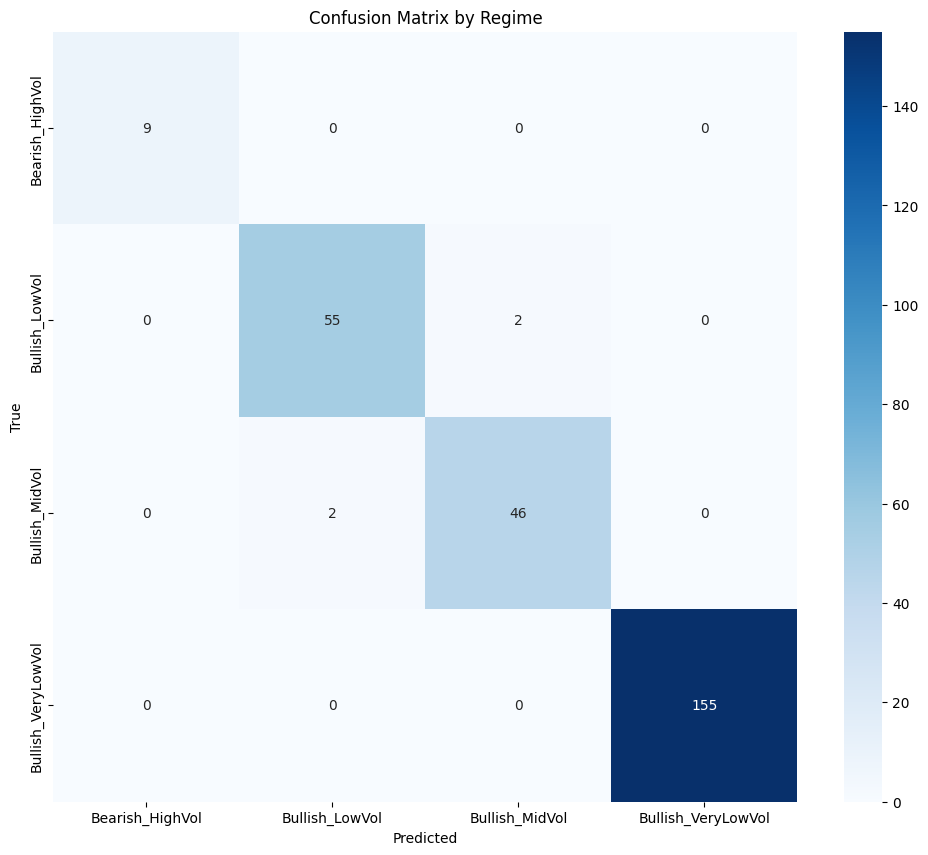

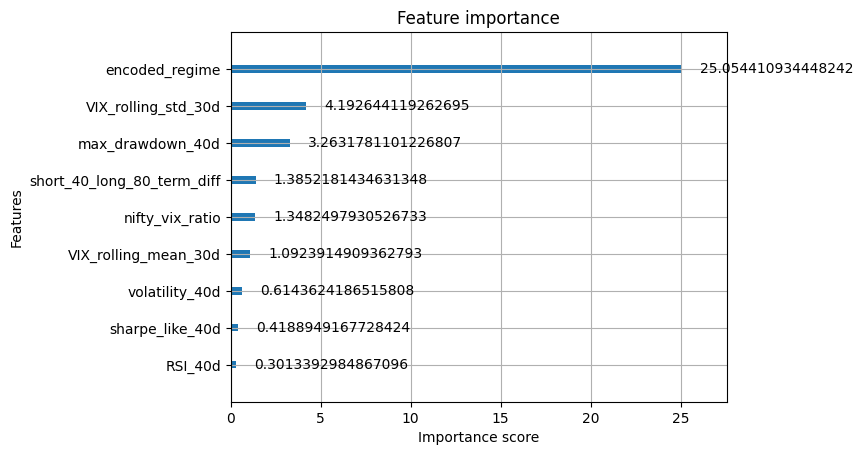

In [ ]:
macro_df_predicted = runModel(df_macro, "macro_regime")

# MICRO

Accuracy: 0.7872340425531915
Balanced Accuracy: 0.8024048084531956
Macro F1: 0.8050963539445645
Weighted F1: 0.785228404446483

Classification Report:
                      precision    recall  f1-score   support

     Choppy_HighVol       1.00      1.00      1.00         7
      Choppy_LowVol       0.86      0.87      0.86        84
      Choppy_MidVol       0.86      0.91      0.88        33
     Neutral_MidVol       0.70      0.58      0.64        24
    Trending_LowVol       0.69      0.66      0.68        62
Trending_VeryLowVol       0.75      0.79      0.77        72

           accuracy                           0.79       282
          macro avg       0.81      0.80      0.81       282
       weighted avg       0.78      0.79      0.79       282

Top-2 Accuracy: 0.950354609929078
Top-3 Accuracy: 0.9929078014184397


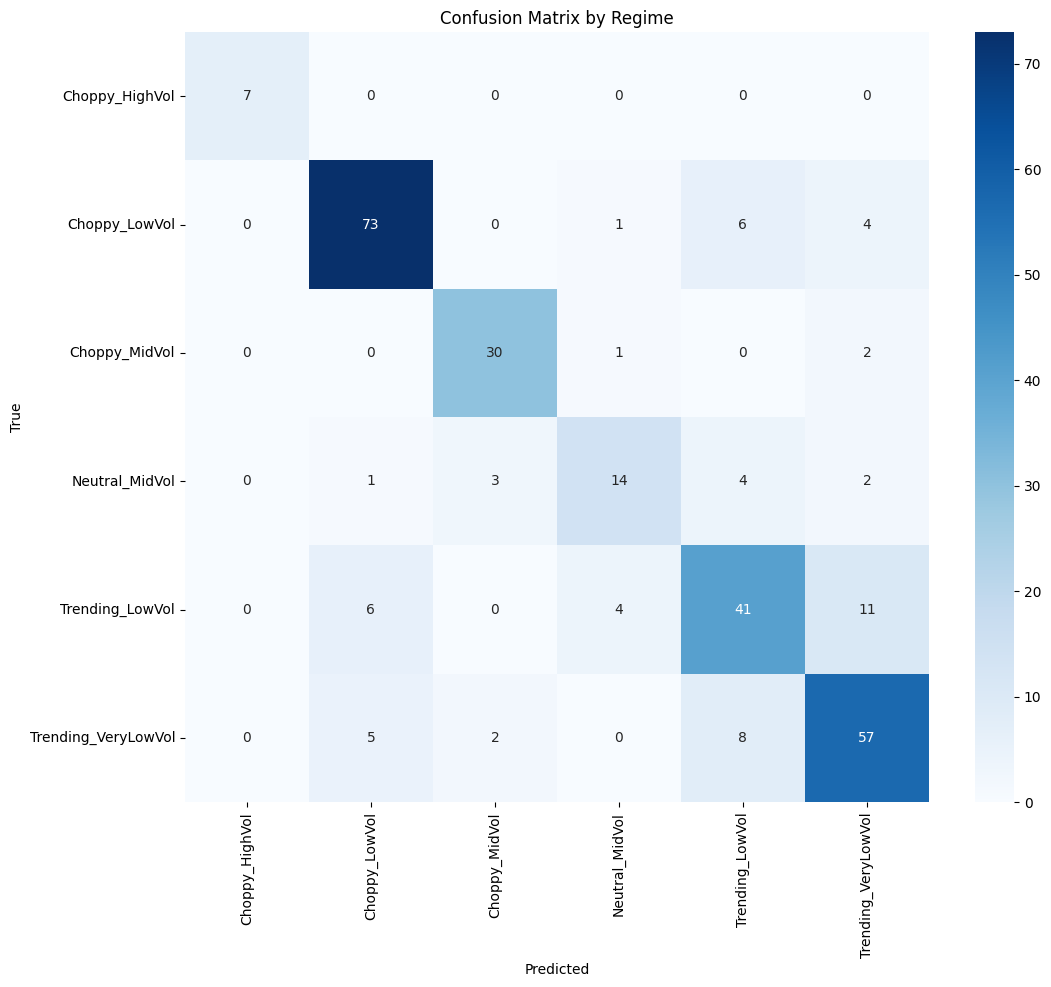

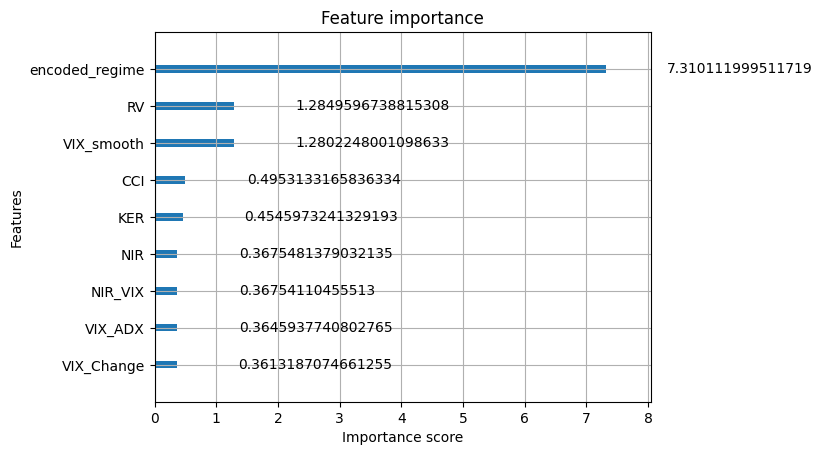

In [ ]:
micro_df_results = runModel(df_micro, "micro_regime")